# **Homework 5: Playing with Pre-trained Models (Extra Credit)**

We **expect** you to complete this assignment in Google Colab. Access to Colab's GPUs will make code run a lot faster, and you can avoid having to locally install the necessary libraries for the lab.
<br/><br/>

This lab makes use of [JAX](https://docs.jax.dev/en/latest/), an automatic differentiation framework from Google that has very similar behavior to `autograd`. It has a couple extra toys we'll see later in this lab. Installing JAX, particularly in a way that allows it to make use of GPU acceleration, can be finicky, so working in the Colab environment will be easier.
<br/><br/>

Working in Colab does come at a cost: it does not save your runtime, so any time you leave the environment and come back to it later you'll need to re-run some cells. You'll also need to re-upload any image files you add to the Colab server.
<br/><br/>

We need to install the pretrained model and import the necessary libraries:

In [1]:
!pip install --upgrade git+https://github.com/matthias-wright/flaxmodels.git

  Cloning https://github.com/matthias-wright/flaxmodels.git to /tmp/pip-req-build-rkayjn1v
  Running command git clone --filter=blob:none --quiet https://github.com/matthias-wright/flaxmodels.git /tmp/pip-req-build-rkayjn1v
  Resolved https://github.com/matthias-wright/flaxmodels.git to commit 09bc77215032375d124e3f1eba828dd89c80a850
  Preparing metadata (setup.py) ... done


In [2]:
import jax
import jax.numpy as jnp # uses the same API as numpy/np and autograd.numpy/ag_np.

from PIL import Image # Python Imaging Library
import flaxmodels as fm # Pre-trained models for our use
import matplotlib.pyplot as plt

## ** Tutorial (Not included in report) **
Upload an image named to the Colab server by clicking the folder on the left and then the upload icon. We'll turn it into a suitable input for a pre-trained Resnet (residual network) architecture.

 `PIL` imports images as containing integer values 0-255 for each pixel, for each of (R,G,B). `Matplotlib` and the Resnet expect float values between 0 and 1, so we need to normalize the data we load.


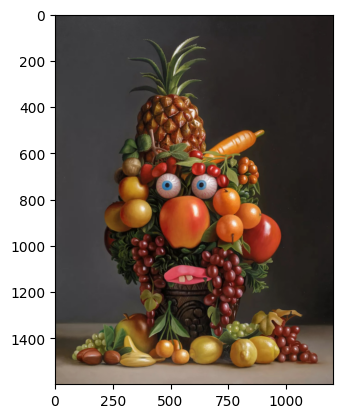

In [3]:
img = Image.open('bubblegum.jpg') # change filename to match your uploaded file
x = jnp.array(img, dtype=jnp.float32) / 255.0
plt.imshow(x)

The resnet architecture was trained on inputs of shape `224 x 224 x 3`, i.e. images that are 224 pixels wide, 224 pixels tall, and contain 3 color channels.

Let's see how big your image is:

In [5]:
x.shape

(1599, 1204, 3)

And let's use `PIL`'s built-in `resize` method to make it 224 by 224.

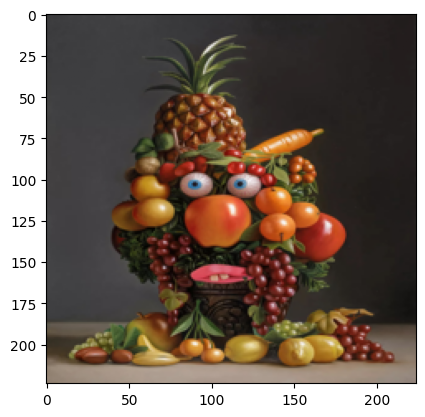

In [6]:
img = img.resize((224, 224))
x = jnp.array(img, dtype=jnp.float32) / 255.0
plt.imshow(x)

Your image is probably blurrier now! 224 is not a ton of pixels. Now let's load in the pre-trained model.

The below lines of code are quite confusing. If you're curious, definitely dig into them! But they're not the central focus of this lab. There are two things at play here:
* To initialize a JAX model, you need to give it a dummy input whose shape matches the inputs you'll give it later. The Resnet expects a minibatch of 224 x 224 x 3 images, and if we want to run it with 1 single image we need a batch of size 1 (1 x 224 x 224 x 3). So we hand it our example image, in a batch of 1, as our dummy input.
* Because JAX expects functions to be pure (they take in inputs, and output outputs, without altering anything along the way) it doesn't do things like setting `model.weight` or `model.bias`. Instead, all parameters are held in a `param` dictionary which is separate from the specification of the model (how you use those parameters to compute the loss).
* Finally, the frustrating part of working in JAX: functions cannot update the random seed ``behind the scenes", because that would be functionally unpure (it's altering a variable without explicitly returning it). Thus anytime your code does something random, you need to manually update the random seed and pass it in as an argument to a function.

In [7]:
# Load image
# Image should be in range [0, 1]
# Add batch dimension
x = jnp.array(img, dtype=jnp.float32) / 255.0
x = jnp.expand_dims(x, axis=0)
key = jax.random.PRNGKey(0)

resnet18 = fm.ResNet18(output='logits', pretrained='imagenet')
params = resnet18.init(key, x)


Downloading: "https://www.dropbox.com/s/wx3vt76s5gpdcw5/resnet18_weights.h5" to /tmp/flaxmodels/resnet18_weights.h5


100%|██████████| 46.9M/46.9M [00:01<00:00, 30.6MiB/s]


In [8]:
# The parameter dictionary is a dictionary of dictionaries.
# For example, each key in params['params'] corresponds to a layer.
params['params'].keys()

dict_keys(['Conv_0', 'BatchNorm_0', 'BasicBlock_0', 'BasicBlock_1', 'BasicBlock_2', 'BasicBlock_3', 'BasicBlock_4', 'BasicBlock_5', 'BasicBlock_6', 'BasicBlock_7', 'Dense_0'])

In [9]:
# Each layer might have multiple parameters (e.g. weight + bias).
# The convolutional layer just has a kernel parameter,
# which I called a filter in class.
params['params']['Conv_0'].keys()

dict_keys(['kernel'])

In [10]:
# Let's check its size: 7 x 7 x 3 x 64.
# Recalling the day where we covered convolutions, this kernel is applied
# to every 7 x 7 patch in the image, and all 3 color channels.
# We get 64 channels out.
params['params']['Conv_0']['kernel'].shape

(7, 7, 3, 64)

In [11]:
# If we want to count the total number of parameters in this
# dictionary-of-dictionaries-of-dictionaries-etc, we can use JAX functions:
sum(x.size for x in jax.tree_util.tree_leaves(params))

11699112

That's a lot of parameters! Almost 12 million, and that's for the smallest pretrained architecture we could find.

Now let's run it on our example image

In [12]:
out = resnet18.apply(params, x, train=False)
out.shape # because our batch size is 1, we get 1 row of 1000=#Classes

(1, 1000)

The first question you might ask: are the values outputted here probabilities, or are they the real-valued scores before the softmax is applied? There's one way to check: does the vector above sum to 1? If yes, they're probabilities, if no, they're scores.

(A heuristic you can also check: are any values negative? If yes, then these are definitely scores)

In [ ]:
# TODO check

Next question: what does each component correspond to?

The 1000 classes here are the ImageNet classes. To figure out which index corresponds to which class, we can download the array.

In [13]:
import urllib.request, json

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
classes = urllib.request.urlopen(url).read().decode("utf-8").splitlines()

print(len(classes))  # 1000
print(classes[:10])


1000
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich']


I've written a helper function to aid you in understanding the model's output

In [14]:
def print_class_probs(out_vector, top_C = 10):
  inds = jnp.argsort(out_vector, descending=True)[:top_C] # take top_C outputs

  probs = jax.nn.softmax(out_vector)

  for i in inds:
    print(f"Class: {classes[i]:<20}    P(Y=y|image): {probs[i]}")


In [15]:
print_class_probs(out[0])

Class: pineapple               P(Y=y|image): 0.813780665397644
Class: orange                  P(Y=y|image): 0.03257519751787186
Class: banana                  P(Y=y|image): 0.031532734632492065
Class: hip                     P(Y=y|image): 0.015782125294208527
Class: vase                    P(Y=y|image): 0.011728357523679733
Class: pomegranate             P(Y=y|image): 0.007646120619028807
Class: maraca                  P(Y=y|image): 0.0056940107606351376
Class: altar                   P(Y=y|image): 0.004939852748066187
Class: toyshop                 P(Y=y|image): 0.004867513198405504
Class: teddy                   P(Y=y|image): 0.004629136528819799


Sweet! Play around with a few images on this model and see what you find.

### GPU Acceleration

Finally, let's take a look at how much faster our code can be when we run it on GPUs instead of CPUs. When you run the cell below, I expect the result to be

`[CpuDevice(id=0)]`

Indicating that the only device you have available for computation is a Google CPU.

In [16]:
jax.devices()

[CpuDevice(id=0)]

How long does it take to perform the forward pass for a single image? The line below will perform the forward pass multiple times, then compute the average (and standard deviation) of those runtimes

In [17]:
%timeit out = resnet18.apply(params, x, train=False)


245 ms ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


JAX has one more tool available to us: Just-in-time (JIT) compilation. Like `autograd.grad` or `jax.grad`, `jax.jit` is a function which takes in functions. It does the following:
* When you first write `f_compiled = jax.jit(f)`, nothing happens.
* The first time you call `f_compiled`, it will perform XLA compilation, which compiles the code to machine-level instructions, which can be run **a lot** faster. Because this compilation is done ``just in time", i.e. when you call the function for the first time, this first call will be slow! But every call after it will be fast.
* The compiled function can be applied to any function **of the same shape.** In this case, if we give it a 1 x 224 x 224 x 3 input, it is compiled to run very fast for any input of the same shape. If we later call `f_compiled` with an input of size 16 x 224 x 224 x 3 (i.e. by having a batch of size 16) then it will need to compile new machine-level instructions to handle this new case! That means it will be very slow again for 1 call, and then fast for all calls with batchsize 1 AND batch size 16.

Finally, note that you can't jit compile everything. Anything with if statements/forking logic cannot be jit compiled unless you know some fancy tricks that I'm happy to teach!

JAX is a wonderful library that can be used to make numpy code a lot faster, even if you're not using the automatic differentiation part of JAX.

In [18]:
def f(x):
  return resnet18.apply(params, x, train=False)

f_compiled = jax.jit(f)

In [19]:
# call it one time so it can compile
_ = f_compiled(x)

# then let's check how fast it is
%timeit f_compiled(x)

71.2 ms ± 6.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### TODO: Try running with GPUs instead of CPUs

Go to Runtime > Change runtime type and select "T4 GPU". You'll have to restart your entire session, i.e. run all cells from the beginning and re-upload your image.

At the end, you should notice that a jit-compiled GPU-accelerated forward pass can be run **about 100 times** faster than a non-jit-compiled CPU forward pass. This stuff really matters for making ML scalable!

# **Problem 1**

Little scaffolding is provided for the tasks in this assignment. The code you need is in past labs and assignments, but I expect you to collect collect things and perform the analysis yourself.

If you pull code from the autograd lab, you'll need to update it to use JAX instead of autograd (e.g. `jnp` instead of `ag_np`, or jax.grad instead of `autograd.grad`).

Instructions are provided in the assignment, including tips if your code is running slow or running out of memory

In [ ]:
# TODO see html page for instructions.

# **Problem 2**: Lime

The code below should get you started in playing with the feature attribution library `lime`.

In [ ]:
!pip install lime

In [ ]:
import numpy as np
from lime import lime_image

def predict_fn(x_np):
    x = jnp.array(x_np) # lime assumes both input and output are numpy arrays
    logits = resnet18.apply(params, x, train=False)
    probs = jax.nn.softmax(logits, axis=-1)
    return np.array(probs) # convert back to numpy

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=np.array(x[0]), # expects an image as input, not a batch
    classifier_fn=predict_fn,
    top_labels=5, # how many classes to build explanations for. Takes the ones with highest probabilities.
    hide_color=0,
    num_samples=1000
)


In [ ]:
# vary this index to check the 5 classes that explanations were built for
label = explanation.top_labels[0]

# Lime sorts the image into regions and ranks them on how influential they are
# to the final prediction. num_features below controls how many regions
# are shown to you. Vary it to understand the relative importance of patches.
masked_image, _ = explanation.get_image_and_mask(
    label,
    positive_only=True,
    num_features=2,
    hide_rest=True
)

print(f"Class: {classes[label]}")
plt.imshow(masked_image)